In [133]:
# ==== Generate LUT.csv for TPA calculations ====
import numpy as np
import pandas as pd
from scipy.constants import c, hbar

def generate_tpa_lut(wavelength, NAv, nr, Epulse, dcf, R, H, Q,
                    r_range=(0, 20e-6, 20),  # r in meters, 20 points
                    z_range=(0, 500e-6, 500)):  # z in meters, 500 points - ACTIVE REGION ONLY
    
    # Constants
    tpalength = wavelength  # wavelength in meters
    tpatau = 160e-15    # pulse duration in seconds
    b = 1.5e-11        # beta_2 in m/W
    f = c/tpalength    # frequency in Hz
    
    # Create coordinate grids - USE CELL CENTERS
    # Calculate step sizes
    dr = (r_range[1] - r_range[0]) / r_range[2]
    dz = (z_range[1] - z_range[0]) / z_range[2]
    
    # Create grids with cell centers (not boundaries)
    r = np.linspace(r_range[0] + dr/2, r_range[1] - dr/2, r_range[2])
    z = np.linspace(z_range[0] + dz/2, z_range[1] - dz/2, z_range[2])
    R_mesh, Z_mesh = np.meshgrid(r, z)
    
    # Calculate beam waist (relative to focus position H)
    waist1 = np.sqrt((tpalength/(np.pi*NAv))**2 + (NAv*(Z_mesh-H)/nr)**2)
    waist2 = np.sqrt((tpalength/(np.pi*NAv))**2 + (NAv*(Z_mesh+H)/nr)**2)
    
    # Calculate TPA rate
    ntpa = ((2*np.sqrt(np.log(4)))/(2*np.pi**3.5) * 
            (Epulse**2*b/(tpatau*hbar*f)) * 
            (1/waist1**4) * 
            np.exp(-4*R_mesh**2/waist1**2))
    
    # Calculate interference term
    nint = (np.sqrt(ntpa * ((2*np.sqrt(np.log(4)))/(2*np.pi**3.5) * 
            (Epulse**2*b/(tpatau*hbar*f)) * 
            (1/waist2**4) * 
            np.exp(-4*R_mesh**2/waist2**2))) * 
            dcf * 2 * R)
    
    # Calculate reflection term
    nref = ((2*np.sqrt(np.log(4)))/(2*np.pi**3.5) * 
            (Epulse**2*b/(tpatau*hbar*f)) * 
            (1/waist2**4) * 
            np.exp(-4*R_mesh**2/waist2**2)) * R**2
    
    # Calculate total rate
    nsum = ntpa + nref + nint
    
    # ==== NORMALIZE TO TOTAL CHARGE Q ====

    # Calculate 3D integral in cylindrical coordinates
    # Volume element: r * dr * dθ * dz, integrated over θ gives 2π
    # Note: dr and dz already calculated above
    total_3d_integral = np.sum(nsum * R_mesh * 2 * np.pi) * dr * dz
    
    # Normalize nsum so total 3D integral equals Q
    nsum = nsum * Q / total_3d_integral
    
#     print(f"Target charge Q: {Q:.2e}")
#     print(f"Original 3D integral: {total_3d_integral:.2e}")
#     print(f"Normalized 3D integral: {np.sum(nsum * R_mesh * 2 * np.pi) * dr * dz:.2e}")
#     print(f"nsum max after normalization: {np.max(nsum):.2e}")
    
    # Calculate final density
    ndia = nsum * 2 * np.pi * R_mesh
    
    # Create DataFrame for return
    df = pd.DataFrame({
        'r': R_mesh.flatten(),
        'z': Z_mesh.flatten(),
        'ndia': ndia.flatten()
    })
    
    return df


In [134]:
# ==== Generate 2D charge lookup table CSV ====
def generate_charge_lut_csv(wavelength, NAv, nr, Epulse, dcf, R, Q,
                           r_range=(0, 20e-6, 200),
                           z_range=(0, 500e-6, 101),      # Full detector range
                           h_range=(-500e-6, 500e-6, 101)): # H center range
    """Generate 2D lookup table: charge(z, H_center) for full detector range"""
    
    # Silent generation - no output
    
    # Constants
    tpalength = wavelength
    tpatau = 160e-15
    b = 1.5e-11
    f = c/tpalength
    
    # Calculate step sizes
    dr = (r_range[1] - r_range[0]) / r_range[2]
    dz = (z_range[1] - z_range[0]) / z_range[2]
    
    # Create coordinate grids
    r = np.linspace(r_range[0] + dr/2, r_range[1] - dr/2, r_range[2])
    z = np.linspace(z_range[0] + dz/2, z_range[1] - dz/2, z_range[2])
    h_centers = np.linspace(h_range[0], h_range[1], h_range[2])
    
    # Pre-calculate constants
    tpa_coeff = (2*np.sqrt(np.log(4)))/(2*np.pi**3.5) * (Epulse**2*b/(tpatau*hbar*f))
    waist0_sq = (tpalength/(np.pi*NAv))**2
    na_over_n = NAv/nr
    
    # Initialize result array: [z_points, h_points]
    charge_lut_2d = np.zeros((len(z), len(h_centers)))
    
    # Processing silently
    
    # For each H center, calculate charge distribution over full z range
    for j, h_center in enumerate(h_centers):
        # Silent processing - no H center output
        
        # Step 1: Calculate TPA for all z positions for this H center
        nsum_3d = np.zeros((len(z), len(r)))  # Store nsum for all z and r
        
        for i, z_val in enumerate(z):
            # Calculate waist (relative to focus position h_center)
            waist1_sq = waist0_sq + (na_over_n * (z_val - h_center))**2
            waist2_sq = waist0_sq + (na_over_n * (z_val + h_center))**2
            
            # TPA calculation for all r at this z
            # Primary beam
            ntpa_row = tpa_coeff * (1/waist1_sq**2) * np.exp(-4*r**2/waist1_sq)
            
            # Reflection beam
            nref_row = tpa_coeff * (1/waist2_sq**2) * np.exp(-4*r**2/waist2_sq) * R**2
            
            # Interference term
            nint_row = np.sqrt(ntpa_row * (tpa_coeff * (1/waist2_sq**2) * np.exp(-4*r**2/waist2_sq))) * dcf * 2 * R
            
            # Total rate (store for all r at this z)
            nsum_3d[i, :] = ntpa_row + nref_row + nint_row
        
        # Step 2: Calculate total 3D integral over ALL z and r for this H
        R_mesh_3d, Z_mesh_3d = np.meshgrid(r, z)
        total_3d_integral = np.sum(nsum_3d * R_mesh_3d * 2 * np.pi) * dr * dz
        
        # Step 3: Normalize entire 3D distribution to total charge Q
        nsum_3d = nsum_3d * Q / total_3d_integral
        
        # Step 4: Calculate charge profile by integrating over r for each z
        for i in range(len(z)):
            ndia_row = nsum_3d[i, :] * 2 * np.pi * r
            charge_lut_2d[i, j] = np.sum(ndia_row) * dr * dz
    
    # Save 2D LUT CSV file
    base_path = '/Users/lihuazhen/Downloads/Diamond_Pipeline/Diamond_Pipeline/Garfield_workplace/'
    
    with open(base_path + 'LUT.csv', 'w') as f:
        f.write(f"# 2D TPA Charge Lookup Table: charge(z, H_center)\n")
        f.write(f"# Rows: z-coordinates [μm], Columns: H-coordinates [μm]\n")
        f.write(f"# z_range: {z[0]*1e6:.1f} to {z[-1]*1e6:.1f} μm\n")
        f.write(f"# H_range: {h_centers[0]*1e6:.1f} to {h_centers[-1]*1e6:.1f} μm\n")
        f.write(f"# Shape: {charge_lut_2d.shape[0]} × {charge_lut_2d.shape[1]}\n")
        f.write("z_um," + ",".join([f"{h*1e6:.1f}" for h in h_centers]) + "\n")
        for i, z_val in enumerate(z):
            f.write(f"{z_val*1e6:.1f}," + ",".join([f"{charge_lut_2d[i,j]:.6e}" for j in range(len(h_centers))]) + "\n")
    
    # File saved silently
    
    return z, h_centers, charge_lut_2d

# Parameters for CSV generation (Diamond only)
wavelength_csv = 405e-9  # Diamond wavelength
nr_csv = 2.4582         # Diamond refractive index
NAv_csv = 0.5
Epulse_csv = 1e-9
dcf_csv = 0.0
Ref_csv = 0.0
Qtotal_csv = 18000

# Generate 2D charge lookup table CSV
z_coords, h_coords, charge_lut_2d = generate_charge_lut_csv(
    wavelength_csv, NAv_csv, nr_csv, Epulse_csv, dcf_csv, Ref_csv, Qtotal_csv,
    r_range=(0, 20e-6, 200),        # Higher resolution
    z_range=(0, 500e-6, 500),       # Full detector range: 0-500μm
    h_range=(-50e-6, 550e-6, 601)  # H center range: -500 to +500μm
)

# CSV generation complete - silent


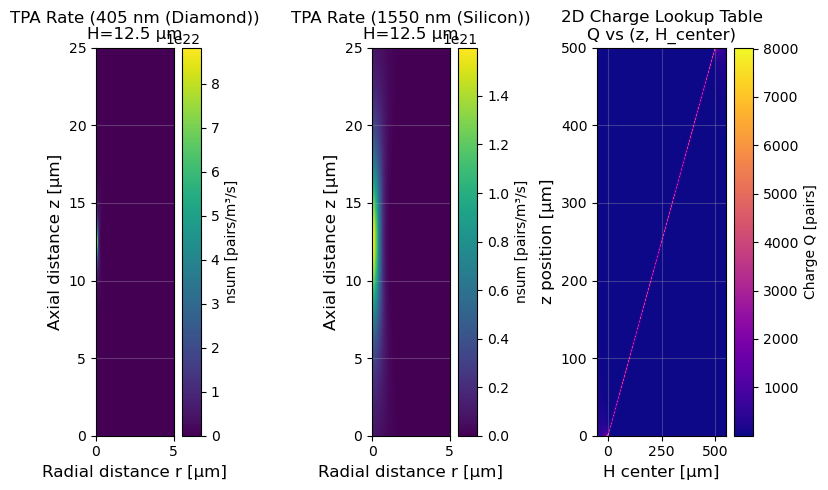

In [135]:
# ==== Plot comparison of two wavelengths ====
import matplotlib.pyplot as plt
import numpy as np

# Common parameters
NAv = NAv_csv      # Numerical aperture (effective)
Epulse = Epulse_csv     # Pulse energy in Joules
dcf = dcf_csv      # Delay factor
Ref = Ref_csv      # Reflection coefficient
Hcenter = 12.5e-6  # Center position in meters
Qtotal = Qtotal_csv    # Total charge (number of electron-hole pairs)

# Two wavelengths and materials to compare
wavelengths = [405e-9, 1550e-9]  # 405 nm and 1550 nm
refractive_indices = [2.4582, 3.48]  # Diamond and Silicon
wl_names = ["405 nm (Diamond)", "1550 nm (Silicon)"]

# Create side-by-side subplots (3 plots)
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

for i, (wavelength, nr, wl_name) in enumerate(zip(wavelengths, refractive_indices, wl_names)):
    
    # Generate LUT data for this wavelength and material (plotting only)
    lut_plot = generate_tpa_lut(wavelength, NAv, nr, Epulse, dcf, Ref, Hcenter, Qtotal, 
                               r_range=(0, 5e-6, 100),    # Coarser grid for plotting
                               z_range=(0, 25e-6, 250))
    
    # Extract just nsum for plotting (without cylindrical weighting)
    r_unique = np.unique(lut_plot['r'])
    z_unique = np.unique(lut_plot['z'])
    # Convert ndia back to nsum by dividing out the cylindrical factor
    ndia_2d = lut_plot['ndia'].values.reshape(len(z_unique), len(r_unique))
    # Create R_mesh with same shape as ndia_2d: (z_points, r_points)
    R_mesh_plot, Z_mesh_plot = np.meshgrid(r_unique, z_unique)
    nsum_2d = ndia_2d / (2 * np.pi * R_mesh_plot)  # Remove cylindrical weighting
    
    # Create color plot
    im = axes[i].pcolormesh(r_unique*1e6, z_unique*1e6, nsum_2d, 
                           shading='auto', cmap='viridis')
    
    # Set equal aspect ratio
    axes[i].set_aspect('equal')
    
    # Set z-axis limits centered around Hcenter
    z_span = 25e-6  # Current z-range span
    z_half_span = z_span / 2
    axes[i].set_ylim((Hcenter - z_half_span)*1e6, (Hcenter + z_half_span)*1e6)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i])
    cbar.set_label('nsum [pairs/m³/s]', fontsize=10)
    
    # Labels and title
    axes[i].set_xlabel('Radial distance r [μm]', fontsize=12)
    axes[i].set_ylabel('Axial distance z [μm]', fontsize=12)
    axes[i].set_title(f'TPA Rate ({wl_name})\nH={Hcenter*1e6:.1f} μm', fontsize=12)
    
    # Add grid
    axes[i].grid(True, alpha=0.3)
    
    # Silent processing

# Third plot: 2D Charge Lookup Table from LUT.csv
# Loading LUT.csv silently

# Read the LUT.csv file
import os
base_path = '/Users/lihuazhen/Downloads/Diamond_Pipeline/Diamond_Pipeline/Garfield_workplace/'
lut_file = base_path + 'LUT.csv'

if os.path.exists(lut_file):
    # Read CSV data, skipping header lines
    lut_data = pd.read_csv(lut_file, comment='#')
    
    # Extract coordinates and data
    z_lut = lut_data.iloc[:, 0].values  # First column: z coordinates
    h_lut = np.array([float(col) for col in lut_data.columns[1:]])  # Column headers: H coordinates
    charge_lut = lut_data.iloc[:, 1:].values  # Data matrix: charge values
    
    # Create 2D plot
    im3 = axes[2].pcolormesh(h_lut, z_lut, charge_lut, 
                            shading='auto', cmap='plasma')
    
    # Add colorbar
    cbar3 = plt.colorbar(im3, ax=axes[2])
    cbar3.set_label('Charge Q [pairs]', fontsize=10)
    
    # Labels and title
    axes[2].set_xlabel('H center [μm]', fontsize=12)
    axes[2].set_ylabel('z position [μm]', fontsize=12)
    axes[2].set_title(f'2D Charge Lookup Table\nQ vs (z, H_center)', fontsize=12)
    
    # Add grid
    axes[2].grid(True, alpha=0.3)
    
    # Data loaded silently
else:
    axes[2].text(0.5, 0.5, 'LUT.csv not found', ha='center', va='center', 
                transform=axes[2].transAxes, fontsize=14)
    axes[2].set_title('2D Charge Lookup Table\n(File not found)', fontsize=12)

# Tight layout and show
plt.tight_layout()
plt.show()

# Silent completion
